# Mood-RL Demonstrations

## Section 1: Summarizing Eldar & Niv (2015)

This section provides an overview of [Eldar & Niv (2015)](https://www.nature.com/articles/ncomms7149).

### Reinforcement Learning Model
In traditional reinforcement learning models, the expected value ($v$) of a stimulus is updated according to a reward prediction error ($\delta$), which reflects the difference between the actual reward obtained ($r$) and the expected value ($\delta = r - v$). This simple framework has proved successful in explaining a wide range of behavioral and neural data. 

To account for effects of mood on valuation, the model is modified to compute predictions errors with respect to *perceived reward* rather than actual reward: 

> $\delta = r_\text{perceived} - v$

where perceived reward ($r_\text{perceived}$) is different from actual reward in that it reflects the biasing effect of mood ($m$):

> $r_\text{perceived} = r \cdot f^m$

Here, $m \in (-1,1)$ where a good mood is indicated by $0 < m < 1$, and a bad mood is indicated by $-1 < m < 0$). $f$ is a positive constant that indicates the direction and extent of the mood bias. If $f=1$, moos does not bias the perception of reward. If $f>1$, mood exerts positive feedback as reward is perceived as larger in a good mood and smaller in a bad mood. Conversely, if $0 < f < 1$, mood exerts negative feedback as reward is perceived as smaller in a good mood and larger in a bad mood. 

To model the effects of unexpected outcomes on mood, mood is assumed to reflect recent prediction-error history ($h$), tracked using a step-size parameters $\eta_h$:

> $h = h + \eta_h (\delta - h)$

and is constrained to -1 and 1 by a sigmoid function:

> $m = \text{tanh} \ h$

Similar to traditional reinforcement learning models, expected values are updated after every trial according to the reward prediction error with a step-size (learning rate) parameter $\eta_v$:

> $v = v + \eta_v \delta$

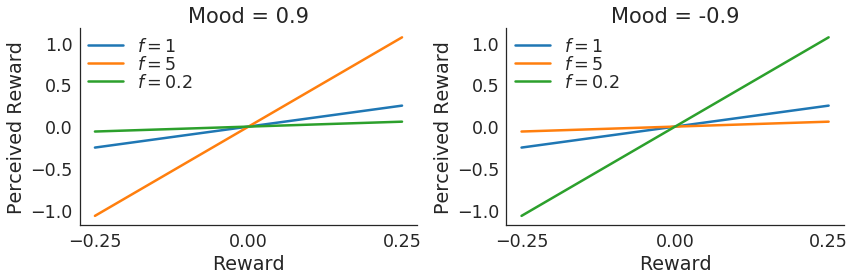

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Define bias function and rewards.
bias = lambda x, f, m: x * f ** m
reward = np.linspace(-0.25, 0.25, 101)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot.
for ax, m in zip(axes, [0.9, -0.9]):
    
    for f in [1, 5, 0.2]:
        
        ax.plot(reward, bias(reward, f, m), lw=2.5, label=r'$f = %s$' %f)
    
    ax.set(xticks=np.linspace(reward.min(),reward.max(),3), xlabel='Reward',
           ylabel='Perceived Reward', title='Mood = %s' %m)
    ax.legend(loc=2, borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

**Figure 1:** Hypothesized effect of mood on reward valuation. In the proposed reinforcement learning model, mood impacts learning through biasing reward valuation. The extent of bias is contingent on mood, $m \in (-1,1)$, and a bias parameter, $f \in (0,\infty)$. When mood is positive (left), agents with bias $f > 1$ exhibit exaggerated reward perception (i.e. $r_{perceived} > r$) whereas agents with bias $f < 1$ exhibit damped  reward perception (i.e. $r_{perceived} < r$). When mood is negative (right), the converse is true. Thus, agents with mood bias, $f \neq 1$, exhibit opposite effects when the sign of mood reverses.

### Results
*To be filled-in*

## Section 2: Simulations

This section demonstrates through simulation the effects of different sets of model parameters on task performance.

### Task Design
Briefly, the task involved participants requiring to learn the reward probabilities of three slot machines. The slot machines yielded reward 20%, 40%, and 60% of the time, respectively. On every trial, participants were presented two of the slot machines and were instructed to select the one that they thought was more likely to return reward. Participants completed three blocks of this task with 42 trials per block. 

Of relevance to simulating task data are the following four features:

1. **Slot machine comparison balance:** trial types are balanced within block. In other words, trials wherein 20% and 40% probability machines are compared are presented the same number of times as trials wherein 20% and 60% probability machines are compared.
2. **Within-subject trial randomization:** trial presentation order are randomized within block. In other words, the likelihood of observing any pair of trials (e.g. *20% vs. 40% probability* then *20% vs. 60% probability*) is approximately equal across participants. Within participants, this balancing is not guaranteed. 
3. **Between-subject trial randomization:** trials are randomized across participants. In other words, every participant will observe a unique order of presented trials. 
4. **Outcome randomization:** rewards are truly randomized. In other words, though the average reward probability of each machine across participants is as designed (i.e. 20%, 40%, 60%), there is variability within participants' experience (e.g. 15%, 45%, 65%).

### Establishing a baseline 
To understand how mood bias affects learning, we must first understand how the canonical reinforcement learning parameters, inverse temperature ($\beta$) and learning rate ($\eta$), impact performance on the slot machine task. In this first segment, we show the range of behavioral performance when bias is absent ($f = 1$). 

For all simulated agents, performance is quantified by the fraction of optimal decisions made, where optimality is defined by choosing the slot machine with objectively higher reward probability. We set as a benchmark for good performance reaching 80% optimal decisions over the course of learning. This is similar to what is actually observed in humans performing this task (see *results_behavior* for details).

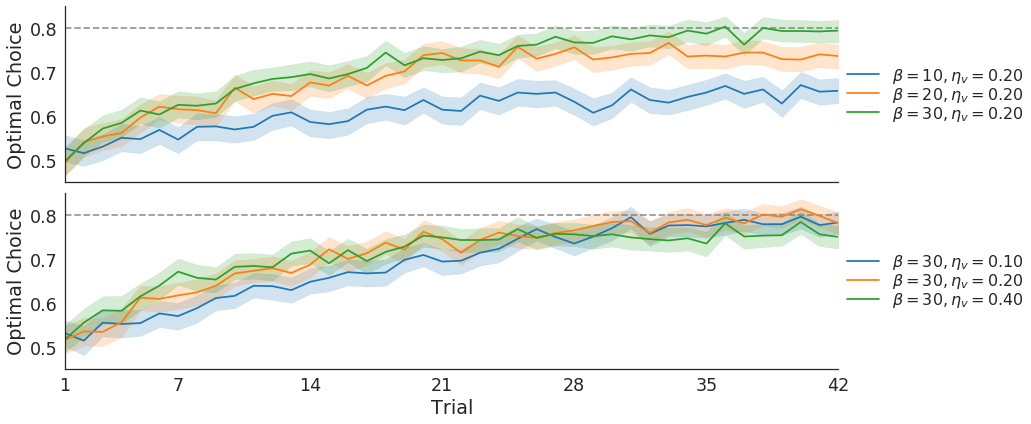

In [2]:
from scripts.simulations import MoodyAgent, DataFrame3d, optimal_choice, slot_machine_game

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define agent paramters (beta, eta_v, eta_h, f).
parameters = [[10, 0.20, 0, 1],
              [20, 0.20, 0, 1],
              [30, 0.20, 0, 1],
              
              [30, 0.10, 0, 1],
              [30, 0.20, 0, 1],
              [30, 0.40, 0, 1]]

## Initial values.
Q = 0.0

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(parameters), n_trials))

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        Y, _ = agent.simulate(X, R, Q=Q)

        ## Compute optimal choices.
        choices[i,j] = optimal_choice(Y, X)

## Convert choices/moods to DataFrame.
fmt = r'$\beta = %s, \eta_v = %0.2f$'
df1 = DataFrame3d(choices[:,:3], major_axis=[fmt %(p[0],p[1]) for p in parameters[:3]])
df2 = DataFrame3d(choices[:,3:], major_axis=[fmt %(p[0],p[1]) for p in parameters[3:]])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig, axes = plt.subplots(2,1,figsize=(12,6))
palette = sns.color_palette(n_colors=3)

## Plot optimal choice.
for ax, data in zip(axes, [df1, df2]):
    sns.lineplot('minor', 'value', 'major', data=data, palette=palette, ax=ax)
    ax.hlines(0.8, 0, n_trials-1, linestyle='--', alpha=0.4, zorder=0)
    ax.set(xlim=(0,n_trials-1), xticks=[], xlabel='', ylim=(0.45, 0.85), 
           yticks=[0.5,0.6,0.7,0.8], ylabel='Optimal Choice')
    ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), fontsize=16, borderpad=0, labelspacing=0)

xticks = np.insert(np.arange(7,43,7),0,1)
ax.set(xticks=xticks-1, xticklabels=xticks, xlabel='Trial')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Performance of canonical RL agents at the slot machine task. RL agents behavior were dictated by two parameters: inverse temperature ($\beta$) and learning rate ($\eta_v$). When the inverse temperature increases (top), performance increases. Human-level performance (70-80%) is achieved at approximately $\beta \geq 20$. Learning progresses more quickly as the learning rate increases (top). Interestingly, as the learning rate increases more, performance begins to plateau and possibly decrease ($\eta_v = 0.40$).

### Mood and RPEs
In the proposed mood-bias RL model, reward perception is biased by mood but mood is reciprocally biased the history of received rewards. To understand the model then, it is necessary to understand how mood evolves with learning. 

We demonstrate the relationship between reward, mood ($m$), and the history parameter ($\eta_h$) in a simplified task where an agent receives a \$0.25 reward on every trial. For simplicity, mood bias is absent ($f=1$) so that mood cannot have a reciprocal effect on learning.

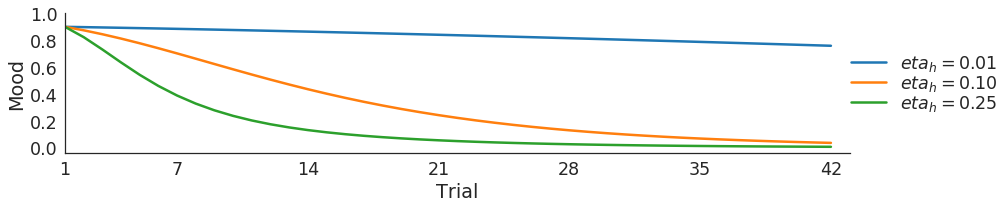

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define agent parameters.
eta_h = [0.01, 0.1, 0.25]
M = 0.9 # Initial mood.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,3))

## Task parameters.
X = np.zeros(42, dtype=int).reshape(-1,1)
R = np.ones_like(X) * 0.25
    
## Iteratively generate moods.
for p in eta_h:
    
    ## Define agent.
    agent = MoodyAgent(beta=20, eta_v=0.1, eta_h=p, f=1)
    
    ## Simulate mood.
    _, mood = agent.simulate(X, R, M=M)
    
    ## Plot.
    ax.plot(mood, lw=2.5, label=r'$eta_h = %0.2f$' %p)
    
## Add info.
ax.set(xlim=(0, X.size), xticks=xticks-1, xticklabels=xticks, xlabel='Trial', 
       yticks=np.linspace(0,1,6), ylabel='Mood')
ax.legend(loc=7, bbox_to_anchor=(1.20,0.5),  borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

**Figure 3:** Simulated effects of reward history on mood. Through a trivial example (i.e. constant reward of \$0.25),  effect of the reward history parameter, $\eta_h$, is clearly observed. Larger values of $\eta_h$ translates to higher weighting of recent RPEs. This translates to a prediction that, in volatile environments, mood will be more variable if $\eta_h$ is high but remain stable if $\eta_h$ is low.

### Dynamic interaction of mood and learning
Above we presented an example where mood bias was absent ($f=1$). When mood bias is present ($f\neq1$), however, mood can bias reward perception, thereby altering reward prediction errors (RPEs). Alterations in RPEs can then in turn impact mood, thereby giving rise to a dynamical system. 

We highlight the complexity of behavior that can arise using again the simplistic scenario from above, i.e. constant reward of 10.

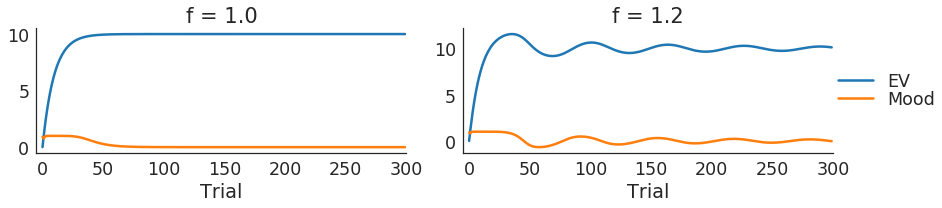

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
parameters = [[10, 0.1, 0.1, 1.0],
              [10, 0.1, 0.1, 1.2]]
m = 0.9

## Task parameters.
R = np.ones(300) * 10

## Preallocate space.
Q = np.zeros((R.size, len(parameters)))
h = np.zeros_like(Q)
M = np.zeros_like(Q)
M[0] += m

## Simulate data.
for j, params in enumerate(parameters):

    ## Unpack parameters.
    beta, eta_v, eta_h, f = params

    for i in np.arange(R.size-1):
        
        ## Compute reward prediction error.
        delta = (f ** M[i,j]) * R[i] - Q[i,j]
        
        ## Update expectations.
        Q[i+1,j] = Q[i,j] + eta_v * delta

        ## Update mood.
        h[i+1,j] = h[i,j] + eta_h * (delta - h[i,j])
        M[i+1,j] = np.tanh(h[i+1,j])
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))

for ax, q, m, f in zip(axes, Q.T, M.T, np.array(parameters)[:,-1]):
    
    ## Plot expectations / mood.
    ax.plot(q, lw=2.5, label='EV')
    ax.plot(m, lw=2.5, label='Mood')
    
    ## Add info.
    ax.set(xlim=(-5,300), xlabel='Trial', title='f = %s' %f)
    
## Add legend.
ax.legend(loc=7, bbox_to_anchor=(1.3,0.5),  borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

**Figure 4:** Simulations of the interaction between learning and mood using a reinforcement learning model. The model was repeatedly exposed to the same outcome of $r = 10$ for 300 iterations for each setting of $f$, the parameter mediating the effect of mood on perception of reward. (Left) With f = 1 (no mood bias), the expected value (EV, blue) converged quickly to the true value and mood (orange) remained stable. (Right) With f = 1.2 (perceived reward positively biased by mood), learned value as well as mood oscillated and did not converge.

### Mood bias on performance
The mood-bias RL model can clearly generate complex learning behaviors. But what effect does it have on task performance?

We demonstrate below that, under certain conditions (such as those chosen in the manuscript), the mood-bias RL model can outperform the canonical two-parameter RL model.

**Note:** This difference in performance fails to show up for many other sets of parameters, so interpret with caution. The potential reasons behind this variability are discussed below.

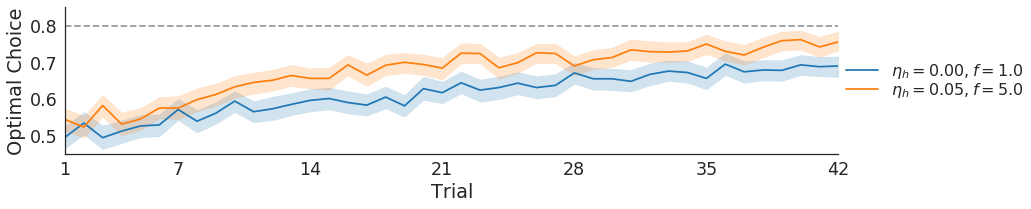

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define agent paramters (beta, eta_v, eta_h, f).
parameters = [[15, 0.10, 0.00, 1],
              [15, 0.10, 0.05, 5]]

## Initial values.
Q = 0.0
M = 0.5

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(parameters), n_trials))

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        Y, _ = agent.simulate(X, R, Q=Q, M=M)

        ## Compute optimal choices.
        choices[i,j] = optimal_choice(Y, X)

## Convert choices/moods to DataFrame.
fmt = r'$\eta_h = %0.2f, f = %0.1f$'
df  = DataFrame3d(choices, major_axis=[fmt %(p[2],p[3]) for p in parameters])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig, ax = plt.subplots(1,1,figsize=(12,3))
palette = sns.color_palette(n_colors=len(parameters))

## Plot optimal choice.
sns.lineplot('minor', 'value', 'major', data=df, palette=palette, ax=ax)
ax.hlines(0.8, 0, n_trials-1, linestyle='--', alpha=0.4, zorder=0)
ax.set(xlim=(0,n_trials-1), xticks=[], xlabel='', ylim=(0.45, 0.85), 
       yticks=[0.5,0.6,0.7,0.8], ylabel='Optimal Choice')
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), fontsize=16, borderpad=0, labelspacing=0)

xticks = np.insert(np.arange(7,43,7),0,1)
ax.set(xticks=xticks-1, xticklabels=xticks, xlabel='Trial')
    
sns.despine()
plt.tight_layout()

**Figure 5:** Mood-bias can improve task performance. The simulated agents above were exposed to 1000 plays of the slot machine game. The canonical and mood-bias RL model had identical inverse temperature and learning rate parameters ($\beta = 15, \eta_v=0.10$) but differed in their reward history and bias parameters. Both agents were initialized at $EV = 0$ and $m = 0$.

## Section 3: Model Comparisons

In this section, we introduce and motivate a number of alternate candidate models that yield similar behavioral predictions as the mood-bias model. We present these model comparisons not to supplant or argue against the mood-bias model, but to better highlight various aspects of its dynamics. (It is also a helpful exercise for this overarching goal of this rotations project, i.e. to think about and fit different RL models.)

### Alternative hypothesis 1: Canonical RL and identifiability issues
A model is identifiable if different parameter settings cannot produce equivalent likelihoods. Put another way, behavioral model is identifiable if no two sets of parameters can generate similar datasets. Reinforcement learning models frequently suffer from identifiability issues ([Daw, 2011](http://www.cns.nyu.edu/~daw/d10.pdf); [Gershman, 2016](http://www.sciencedirect.com/science/article/pii/S0022249616000080)). The inverse temperature and learning rate parameters typically exhibit an anticorrelations such that multiple sets of parameters can explain the same observations (e.g. $\beta = 20$ and $\eta = 0.1$ vs. $\beta = 10$ and $\eta = 0.2$). Identifiability for reinforcement learning models can be improved through the use of informed priors [Gershman, 2016](http://www.sciencedirect.com/science/article/pii/S0022249616000080)) or hierarchical modeling ([Gelman et al., 2013](https://www.crcpress.com/Bayesian-Data-Analysis-Third-Edition/Gelman-Carlin-Stern-Dunson-Vehtari-Rubin/p/book/9781439840955); [Kruschke, 2014](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0)).

One *a priori* concern about the mood-bias RL model is that identifiability issues may become exaggerated under certain conditions. Specifically, when mood is relatively stable (low variance), the mood bias parameter ($f$) may act similarly to a constant. It can be shown there are sets of parameters $\eta_v$, $f$, and $m$ that make equivalent behavioral predictions (see Appendix for derivation). Conceptually, $\eta_v$ and $f$ can become confounded such that either can change the magnitude of the expectation updating in learning. 

These concerns are mitigated when mood is variable and especially when mood changes sign. Remember that when mood changes sign, the effects on perceived reward are reversed. The learning rate parameter cannot both increase and decrease the scale of reward expectation updating, and therefore the role must fall to the bias parameter. It is important then to be wary of high numbers of participants with low variability in mood but especially wary of participants with no sign flip in mood.

### Alternative hypothesis 2: Dual Learning Rates
A number of studies have found that reinforcement learning behavior is best described with dual learning rates: one for positive RPEs and one for negative RPEs ([Daw et al., 2002](http://www.sciencedirect.com/science/article/pii/S0893608002000527); [Frank et al., 2007](http://www.pnas.org/content/104/41/16311); [Frank et al., 2009](https://www.nature.com/articles/nn.2342); [Niv et al., 2012](http://www.jneurosci.org/content/32/2/551); [Gershman, 2015](https://link.springer.com/article/10.3758%2Fs13423-014-0790-3); [Gershman, 2016](http://www.sciencedirect.com/science/article/pii/S0022249616000080)). A dual learning model may similarly account for at least some of the behavior of the mood bias model. 

Consider the complete Q-learning rule for the mood bias model:

> $v_{i+1} = v_i + \eta_v (r_i \cdot f^m - v_i)$

An interesting pattern emerges when we plug in for the possible values of reward, $r$, in the slot machine task:

> $v_{i+1} = \begin{cases} v_i + \eta_v (r_i \cdot f^m - v_i) \ \ \ if \ r_i \neq 0 \\
v_i - \eta_v v_i \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ r_i = 0 \end{cases} $

These formulas are similar (but not equivalent) to a reinforcement learning model with two learning rates, $\eta_+$ and $\eta_-$.

> $v_{i+1} = \begin{cases} v_i + \eta_+ (r_i - v_i) \ \ \ if \ r_i > 0 \\
v_i - \eta_- v_i \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ r_i = 0 \end{cases} $

Of course, the mood-biased and dual RL  models are not truly equivalent due to the dynamic nature of the bias parameter. Insofar that mood is variable, the value of $f^m$ changes and is thus not constant like $\eta_+$. If mood shows little to no variability, however, the models make increasingly similar predictions. 

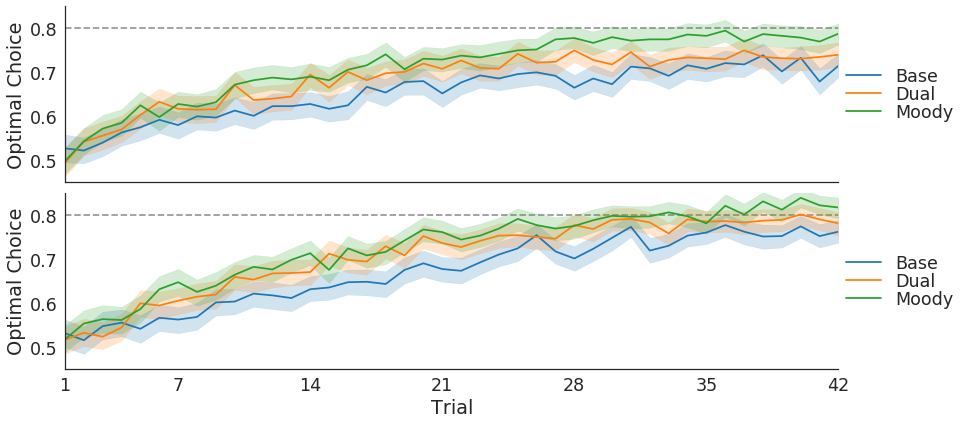

In [6]:
from scripts.simulations import DualLearningAgent

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
agents = [DualLearningAgent(beta=15, eta_p=0.2, eta_n=0.2),
          DualLearningAgent(beta=15, eta_p=0.3, eta_n=0.05),
          MoodyAgent(beta=15, eta_v=0.2, eta_h=0.01, f=5),
          
          DualLearningAgent(beta=25, eta_p=0.1, eta_n=0.1),
          DualLearningAgent(beta=25, eta_p=0.2, eta_n=0.05),
          MoodyAgent(beta=25, eta_v=0.1, eta_h=0.01, f=5)]

## Initial values.
Q = 0.0
M = 0.5

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(agents), n_trials))

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, agent in enumerate(agents):
        
        ## Play block of slot machine game.
        try: 
            Y, _ = agent.simulate(X, R, Q=Q, M=M)
        except TypeError: 
            Y = agent.simulate(X, R, Q=Q)
    
        ## Compute optimal choices.
        choices[i,j] = optimal_choice(Y, X)        
    
## Convert choices/moods to DataFrame.
major_axis = ['Base', 'Dual', 'Moody']
df1 = DataFrame3d(choices[:,:3], major_axis=major_axis)
df2 = DataFrame3d(choices[:,3:], major_axis=major_axis)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig, axes = plt.subplots(2,1,figsize=(12,6))
palette = sns.color_palette(n_colors=3)

## Plot optimal choice.
for ax, data in zip(axes, [df1, df2]):
    sns.lineplot('minor', 'value', 'major', data=data, palette=palette, ax=ax)
    ax.hlines(0.8, 0, n_trials-1, linestyle='--', alpha=0.4, zorder=0)
    ax.set(xlim=(0,n_trials-1), xticks=[], xlabel='', ylim=(0.45, 0.85), 
           yticks=[0.5,0.6,0.7,0.8], ylabel='Optimal Choice')
    ax.legend(loc=7, bbox_to_anchor=(1.16,0.5), borderpad=0, labelspacing=0)

xticks = np.insert(np.arange(7,43,7),0,1)
ax.set(xticks=xticks-1, xticklabels=xticks, xlabel='Trial')
    
sns.despine()
plt.tight_layout()

**Figure 6:** The dual and mood bias RL models make similar behavior predictions. When the inverse temperature parameter is lower (top, $\beta=15$), the dual learning rate model is similar to the mood bias model early but diverges in performance in later trials. When the inverse temperature parameter is higher (top, $\beta=25$), the models make largely similar predictions. In both scenarios, the canonical RL model performs worse.

### Alternative hypothesis 3: Dynamic Parameters
Several studies have investigated the possibility of adaptive inverse temperature ([Busemeyer & Stout, 2002](http://psycnet.apa.org/record/2002-17916-003); [Ahn et al., 2008](http://onlinelibrary.wiley.com/doi/10.1080/03640210802352992/abstract)) and learning rates ([Krugel et al., 2009](http://www.pnas.org/content/106/42/17951.long)). The bias parameter with mood ($f^m$) implicitly acts as a dynamic weight on the learning rate ($\eta_v$). In addition, we have observed in simulations that the reward history parameter ($eta_h$) imbues the model with an adaptive feature: when $eta_h>0$ and $f>1$, mood is pulled towards zero as learning occurs (i.e. $\delta \rightarrow 0$) which thereby reduces $f$ and $\delta$. 

One benefit (or drawback) of the mood bias model is that the bias ($f$) may allow for dynamism in learning rates even when the change in mood is small. Consider for example a scenario in which, for some dataset, the best fitting model requires $f$ to change by $d$ over the course of a block ($d = f_{42} - f_1$). If mood changed from 0.5 to 0.0 ($\Delta 0.5$) over the course of the block, the best-fitting $f$ to achieve $d$ is ~1.35. If mood changed from 0.50 to 0.45 ($\Delta 0.05$) over the course of the block, the best-fitting $f$ to achieve $d$ is ~5.00. If we assume that mood is actually independent of learning, then the $f$ parameter can be arbitrarily fit to some value so as to allow for adaptive learning rates

This confounding of $f$ is mitigated, however, when ever there is a non-monotonic change in mood. When mood changes non-monotonically, the model would assume that learning is not adaptive linearly (i.e learning rates decrease then increase again). Though this is possible in certain datasets (e.g. reversal learning), it is unlikely in the more straightforward slot machine game. It is important then to be wary of participants with monotonic changes in mood.

## Appendix
### Equivalence of learning rate ($\eta$) and bias ($f$)
Take the formulas from above and plug them in to arrive at one equation: 

> $v_{i+1} = v_i + \eta_v (r_i \cdot f^m - v_i)$

Assuming fixed values and rewards, $v_i$ and $r_i$, for trial $i$, let us find where different values of the parameters give rise to the same learning updates:

> $ v + \eta_1 (r \cdot f_1^m - v) = v + \eta_2 (r \cdot f_2^m - v) $ 

Simplified: 

> $ \eta_1 (r \cdot f_1^m - v) = \eta_2 (r \cdot f_2^m - v) $ 

Multiply it out:

> $ r f_1^m \eta_1 - v \eta_1 = r f_2^m \eta_2 - v \eta_2$

Trade it out:

> $ r f_1^m \eta_1 - r f_2^m \eta_2  = v \eta_1 - v \eta_2$

Pull out:

> $ r(f_1^m \eta_1 - f_2^m \eta_2 ) = v( \eta_1 - \eta_2 ) $

Only simplifying assumption we make, assume $v = 0$ at trial $i=1$: 

> $ f_1^m \eta_1 - f_2^m \eta_2 = 0 $

> $ f_1^m \eta_1 = f_2^m \eta_2 $

> $ \frac{\eta_1}{\eta_2} = \frac{f_2^m}{f_1^m} $

> $ log(\eta_1) - log(\eta_2) = m \cdot log(f_2) - m \cdot log(f_1)$

> $ log(\eta_1) - log(\eta_2) = m (log(f_2) - log(f_1))$

> $ \frac{log(\eta_1) - log(\eta_2)}{log(f_2) - log(f_1))} = m $